# 3. Implementation of XY-Mixers with Transformations

## Overview

As we have just learned, alternative, more suitable methods exist for handling constraints with QAOA. Mixer methods help to constrain the Hilbert search space to only the feasible solutions of the optimization problem. By searching only in the feasible subspace, performance generally improves drastically. However, identifying suitable mixers is often hard for general constraints without known structure. Still, the One-Hot constraints we have in our _Session Chair Assignment_ problem are well-suited, as we have already learned, due to their regular structure of feasible states.

In this notebook, you will implement
1. The $\ket{W}$ state preparation circuit, which is the superposition of all feasible states.
2. The $XY$-Ring Mixer circuit.

In [1]:
# import matplotlib.pyplot as plt
import numpy as np

# Optimization modeling library
from luna_quantum import (
    Comparator,
    HigherOrder,
    Linear,
    Model,
    Quadratic,
    Variable,
    Vtype,
)

# Utility functions for Transformations
from luna_quantum.decorators import analyse, transform

# Transformations
from luna_quantum.transformations import (
    IR,
    ActionType,
    AnalysisCache,
    MaxBiasAnalysis,
    PassManager,
    TransformationOutcome,
)

# Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import Operator, Statevector

# Import model data
from model.data import ConventionCenter, Schedule, SessionChair
from model.model import optimization_model
from model.visualization import (
    plot_floor_plan,
    solution_to_assignment,
)

# Import utils (from last notebooks)
from utils import optimize_and_plot, pretty
from utils.qaoa import rx_mixer_layer

## The Session Chair Assignment Problem, Again

We use the same problem as investageted in the last notebook here as well.

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

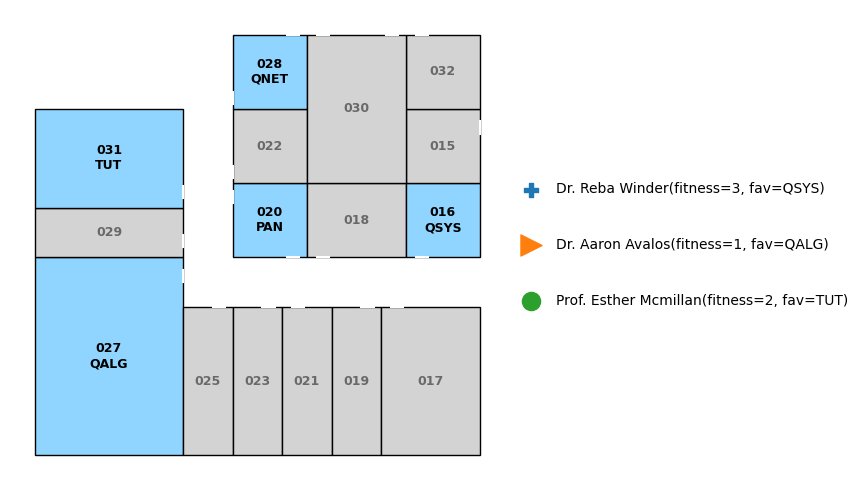

In [2]:
center = ConventionCenter.generate()
schedule = Schedule.random(5, center, seed=5)
chairs = SessionChair.random_chairs(3, schedule=schedule, seed=2)

satisfaction = 2

plot_floor_plan(center, schedule=schedule, chairs=chairs)

In [3]:
x, model = optimization_model(center, schedule, chairs, satisfaction=satisfaction)

## Identify and Remove One-Hot Constraints

As a first processing step, our transformation pipeline has to identify the one-hot constraints to be handled by the circuit generator at a later stage. To this end, we employ two new passes
- An `AnaylsisPass` that identifies the one-hot constraints.
- An `TransformationPass` that removes the one-hot constraints from the model.

Instead of inheriting from the base passes, this time we use a convenience decorator to do the job. If a task is comparatively simple and has no additional parameters are required, this decorator pattern is especially convenient.

In [4]:
@analyse()
def identify_one_hot(model: Model, _: AnalysisCache):
    """Identifies one-hot constraints present in the model."""
    onehots: list[int | str] = []

    # Hint: Loop over the constraints and note down all constraints of type one-hot constraint.
    # This is the case if the `comparator` is equality, all items are linear and all biases are equal.
    ##TASK>
    for i, constraint in enumerate(model.constraints):  #
        # Equality
        if constraint.comparator != Comparator.Eq:
            continue
        # Only linear terms
        if constraint.lhs.has_quadratic() or constraint.lhs.has_higher_order():
            continue
        # All biases are equal
        if not all(v == constraint.rhs for k, v in constraint.lhs.linear_items()):
            continue
        onehots.append(constraint.name or i)
    ##<TASKEND

    return onehots


@transform(requires=["identify-one-hot"], invalidates=["identify-one-hot"])
def remove_one_hot(model: Model, cache: AnalysisCache):
    """Removes one-hot constraints from the model."""
    one_hots: list[int | str] = cache["identify-one-hot"]

    if len(one_hots) == 0:
        return TransformationOutcome.nothing(model)

    # Extract one hot constraint information
    one_hot_info: dict[int | str, set[Variable]] = {}
    for i in one_hots:
        c = model.constraints[i]
        variables = [item.var for item, _ in c.lhs.items() if isinstance(item, Linear)]
        one_hot_info[i] = variables

    # Remove constraints
    for k, c in one_hot_info.items():
        model.constraints.remove(k)

    return model, ActionType.DidTransform, {"removed": one_hot_info}


pass_manager = PassManager([identify_one_hot, remove_one_hot, MaxBiasAnalysis()])

We can test the pass manager now. We should expect that all constraints were simply removed.

In [5]:
ir = pass_manager.run(model)
print(ir.model)

print("\nRemoved:")
print(list(ir.cache["remove-one-hot"]["removed"].keys()))

Model: Session chair assignment
Minimize
  8.5 * x_016_0 * x_028_0 + 4 * x_016_0 * x_020_0 + 5.5 * x_016_0 * x_031_0 
  + 4.8 * x_016_0 * x_027_0 + 25.5 * x_016_1 * x_028_1 + 12 * x_016_1 * x_020_1 
  + 16.5 * x_016_1 * x_031_1 + 14.4 * x_016_1 * x_027_1 + 17 * x_016_2 * x_028_2
  + 8 * x_016_2 * x_020_2 + 11 * x_016_2 * x_031_2 + 9.6 * x_016_2 * x_027_2 
  + 3.5 * x_028_0 * x_020_0 + 3.9 * x_028_0 * x_031_0 + 5.4 * x_028_0 * x_027_0 
  + 10.5 * x_028_1 * x_020_1 + 11.7 * x_028_1 * x_031_1 
  + 16.2 * x_028_1 * x_027_1 + 7 * x_028_2 * x_020_2 + 7.8 * x_028_2 * x_031_2 
  + 10.8 * x_028_2 * x_027_2 + x_020_0 * x_031_0 + 1.9 * x_020_0 * x_027_0 
  + 3 * x_020_1 * x_031_1 + 5.7 * x_020_1 * x_027_1 + 2 * x_020_2 * x_031_2 
  + 3.8 * x_020_2 * x_027_2 + 1.7 * x_031_0 * x_027_0 + 5.1 * x_031_1 * x_027_1 
  + 3.4 * x_031_2 * x_027_2 - 2 * x_016_0 - 2 * x_031_2 - 2 * x_027_1
Binary
  x_016_0 x_016_1 x_016_2 x_028_0 x_028_1 x_028_2 x_020_0 x_020_1 x_020_2 
  x_031_0 x_031_1 x_031_2 x_027_0 x_02

---
## Circuits

Now, we can focus on constructing the circuit out of this **Intermediate Representation**. This time, we need the full context of the transformation pipeline itself to build the final circuit. Just the model does not suffice, since we do not know anymore, that the One-Hot Constraints are handled differently from the output model only.

Taking the **IR** as input, gives the full context.

### W-State

First, let us focus on a single $\ket{W}$ state. We use the ladder construction given in ["Efficient Quantum Algorithms for GHZ and W States..."](https://arxiv.org/abs/1807.05572)

<img src="../assets/w_state.png" width=400px />

That means we have to initialize one qubit in $\ket{1}$, then we iteratively apply a controlled $G$ gate and a CNOT in reverse. The $G(p)$ gate is defined as
$$ G(p) = \begin{pmatrix}\sqrt{p} &-\sqrt{1 - p} \\\sqrt{1-p} & \sqrt{p}\end{pmatrix} = R_Y\left(2 \arccos(\sqrt{p})\right)$$

In [6]:
def w_state(num: int):
    """Circuit for the W-State with `num` qubits"""
    qc = QuantumCircuit(num)
    assert num >= 2
    ##TASK>
    if num == 2:
        qc.h(0)
        qc.x(1)
        qc.cx(0, 1)
    else:
        qc.x(0)
        for i in range(num - 1):
            angle = 2 * np.arccos(np.sqrt(1 / (num - i)))
            qc.cry(angle, i, i + 1)
            qc.cx(i + 1, i)
    ##<TASKEND
    return qc

Let's test this circuit on 6 qubits for instance.

0.167|000001> + 0.167|000010> + 0.167|000100> + 0.167|001000> + 0.167|010000> + 0.167|100000>

🎉 It worked!


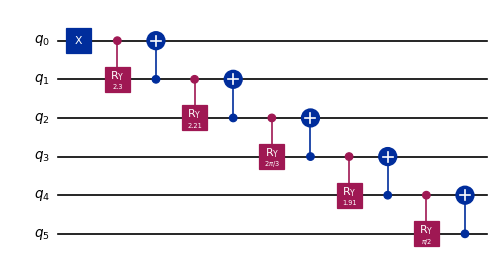

In [7]:
num = 6
probs = Statevector(w_state(num)).probabilities_dict()

print(" + ".join(f"{v:.3f}|{k}>" for k, v in probs.items()))

if all(map(lambda x: np.isclose(x, 1 / num), probs.values())):
    print("\n🎉 It worked!")

w_state(num).draw("mpl", scale=0.6)

The initial state for the full QAOA circuit that comprises of both variables handled via one-hot constraints and plain binary variables can be constructed by assigning W-State generation circuits to those variables that are one-hot constrained and $H$ gates to the other ones.

For this we use the convention that the $i$-th qubit the register corresponds to the $i$-th variable in the model. The `varmap` dic allows you to go from variable to qubit index.

In [8]:
def initial_state(ir: IR):
    """Implements the initial state for an arbitrary IR.

    Parameters
    ----------
    ir: IR
        The intermediate representation of the model transformation.

    Returns
    -------
    QuantumCircuit
    """
    qc = QuantumCircuit(len(ir.model.variables()))
    remove_one_hot = ir.cache["remove-one-hot"]
    if remove_one_hot is None:
        qc.h(qc.qubits)
    else:
        varmap = {v: i for i, v in enumerate(ir.model.variables())}

        ##TASK>
        one_hots = remove_one_hot["removed"]
        one_hot_vars = set(i for v in one_hots.values() for i in v)

        # Normal initial state
        if qc.num_qubits - len(one_hot_vars) > 0:
            qc.h([i for v, i in varmap.items() if v not in one_hot_vars])

        # W-state
        for w in one_hots.values():
            qc.compose(w_state(len(w)), [varmap[i] for i in w], inplace=True)
        ##<TASKEND

    return qc

Testing this for the IR just generated for the Session Chair assignment problem, we can see expected placement of the corresponding gates.

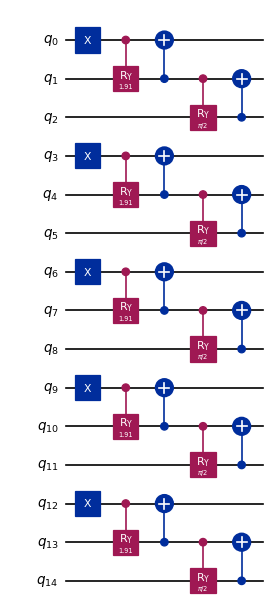

In [9]:
initial_state(ir).draw("mpl", scale=0.6)

The Session Chair Assignment Problem consists of just one-hot constrained vars. Therefore, we now develop a toy-model that has mixed variables

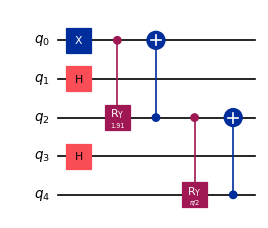

In [10]:
m = Model()
y = [m.add_variable(f"y_{i}") for i in range(5)]
m.add_constraint(y[0] + y[2] + y[4] == 1)
initial_state(pass_manager.run(m)).draw("mpl", scale=0.6)

As we can see, the initial state generation works as expected.

---
### XY-Mixer

At the core of the $XY$-mixer is the $R_{XY}(\beta) = e^{-i \beta (XX + YY) / 2}$. All $XY$-mixers are comprosed of this building block gate.

$$R_{XY}(\beta) = R_{YY}(\beta) R_{XX}(\beta) = \begin{pmatrix} 1 \\ & \cos(\beta) & -i \sin(\beta) \\ & -i \sin(\beta) & \cos(\beta) \\ &&& 1 \end{pmatrix}$$

In [11]:
def rxy(beta: Parameter | float):
    """Implement single XY rotation.

    Parameters
    ----------
    beta: float | Parameter
        The beta parameter.

    Returns
    -------
    QuantumCircuit
    """
    qc = QuantumCircuit(2)
    ##TASK>
    qc.rxx(beta, 0, 1)
    qc.ryy(beta, 0, 1)
    ##<TASKEND
    return qc

In [12]:
# Let's test by investigating the operator matrix
Operator(rxy(1)).to_matrix().round(3)

array([[1.  +0.j   , 0.  +0.j   , 0.  +0.j   , 0.  +0.j   ],
       [0.  +0.j   , 0.54+0.j   , 0.  -0.841j, 0.  +0.j   ],
       [0.  +0.j   , 0.  -0.841j, 0.54+0.j   , 0.  +0.j   ],
       [0.  +0.j   , 0.  +0.j   , 0.  +0.j   , 1.  +0.j   ]])

Next step is to implement the ring mixer as discussed in ["From the Quantum Approximate Optimizaton Algorithm to the ..."](https://arxiv.org/abs/1709.03489)

<img src="../assets/xy_ring.png" width=800px style="display: block; margin-left: auto; margin-right: auto"/>

In [13]:
def xy_mixer(num: int, beta: Parameter | float):
    """Implement the XY-ring-mixer.

    Parameters
    ----------
    num: int
        The number of qubits that are part of this ring mixer.
    beta: float | Parameter
        The beta parameter.

    Returns
    -------
    QuantumCircuit
    """
    qc = QuantumCircuit(num)
    assert num >= 2
    if num == 2:
        qc.compose(rxy(beta), (0, 1), inplace=True)
    else:
        ##TASK>
        uxy = rxy(beta)
        pairs = [(i, i + 1) for i in range(0, num - 1, 2)] + [  # even
            (i, i + 1)
            for i in range(1, num - 1, 2)  # odd
        ]
        pairs.append((0, num - 1))  # last / last odd
        for p in pairs:
            qc.compose(uxy, p, inplace=True)
        ##<TASKEND
    return qc

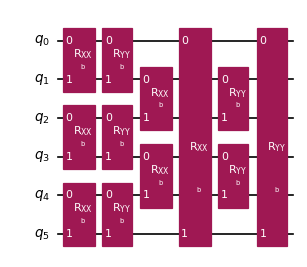

In [14]:
xy_mixer(6, Parameter("b")).draw("mpl", scale=0.6)

In [15]:
def combined_mixer(ir: IR, beta: Parameter | float):
    """Implement the combined mixer.

    Automatically applies normal X-mixer or combined mixer depending on IR

    Parameters
    ----------
    ir: IR
        The intermediate representation of the model transformation.
    beta: float | Parameter
        The beta parameter.

    Returns
    -------
    QuantumCircuit
    """
    remove_one_hot = ir.cache["remove-one-hot"]
    if remove_one_hot is None:
        return rx_mixer_layer(len(ir.model.variables()), beta)

    qc = QuantumCircuit(len(ir.model.variables()))
    varmap = {v: i for i, v in enumerate(ir.model.variables())}

    # Similar to the initial state generator, we have to assign the xy mixer to the associated variables.
    ##TASK>
    one_hots = remove_one_hot["removed"]
    one_hot_vars = set(i for v in one_hots.values() for i in v)

    # Normal X-Mixer
    if qc.num_qubits - len(one_hot_vars) > 0:
        qc.compose(
            rx_mixer_layer(qc.num_qubits - len(one_hot_vars), beta),
            [i for v, i in varmap.items() if v not in one_hot_vars],
            inplace=True,
        )

    # XY-Mixer
    for w in one_hots.values():
        qc.compose(xy_mixer(len(w), beta), [varmap[i] for i in w], inplace=True)
    ##<TASKEND

    return qc

**Next is to adapt the circuit generator functions**. We call the advanced functions that now take in an IR `_adv`. There is now task for you in the coming code block. These are just minor adjustments of the files developed in [01_QAOA](01_QAOA.ipynb).

In [16]:
def cost_layer_adv(ir: IR, gamma: Parameter | float):
    """Implements a single QAOA cost operation.

    Parameters
    ----------
    ir: IR
        The intermediate representation containing the transformed objective function
        and model metadata
    gamma: Parameter | Float
        Cost parameter (controls problem-specific rotations)

    Returns
    -------
    QuantumCircuit
        A single QAOA cost layer
    """
    qc = QuantumCircuit(len(ir.model.variables()))

    # The only change is here where we automatically normalize for 'max-bias'
    max_bias = ir.cache["max-bias"].val
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

    # Mapping from variables to qubit indices
    varmap = {v: i for i, v in enumerate(ir.model.variables())}

    for item, val in ir.model.objective.items():
        angle = val * gamma / max_bias
        match item:
            case Linear(v):
                # Linear terms: single-qubit phase gate
                qc.p(angle, varmap[v])
            case Quadratic(v1, v2):
                # Quadratic terms: two-qubit controlled-phase gate applied to |11>
                qc.cp(angle, varmap[v1], varmap[v2])
            case HigherOrder(vs):
                # HigherOrder terms: muti-qubit controlled-phase gate applied to |11..11>
                qc.mcp(angle, [varmap[v] for v in vs[:-1]], varmap[vs[-1]])

    return qc


def qaoa_layer_adv(
    ir: IR, beta: Parameter | float, gamma: Parameter | float
) -> QuantumCircuit:
    """Implements a single advanced QAOA layer consisting of cost and mixer operations.

    Parameters
    ----------
    ir: IR
        The intermediate representation containing the transformed objective function
        and model metadata
    beta: Parameter | Float
        Mixer parameter (controls X-rotations)
    gamma: Parameter | Float
        Cost parameter (controls problem-specific rotations)

    Returns
    -------
    QuantumCircuit
        A single QAOA layer
    """

    qc = cost_layer_adv(ir, gamma)
    qc = qc.compose(combined_mixer(ir, beta))
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    assert qc is not None

    return qc


def qaoa_circ_adv(ir: IR, reps: int = 1) -> QuantumCircuit:
    """Generates a complete advanced QAOA circuit with specified number of layers.

    Parameters
    ----------
    ir: IR
        The intermediate representation containing the transformed objective function
        and model metadata
    reps: int
        Number of QAOA layers (p parameter)

    Returns
    -------
    QuantumCircuit
        Complete QAOA circuit with measurements
    """
    # Verify the model is suitable for QAOA
    assert ir.model.num_constraints == 0, "QAOA requires unconstrained problems"
    assert all(v.vtype == Vtype.Binary for v in ir.model.variables()), (
        "All variables must be binary"
    )

    # Start with equal superposition state |+⟩^⊗n \otimes |W>
    qc = initial_state(ir)
    # ^^^^^^^^^^^^^^^^^^^^

    # Create parameter templates for a single layer
    beta = Parameter("beta")
    gamma = Parameter("gamma")
    layer_circ = qaoa_layer_adv(ir, beta, gamma)
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

    # Create individual parameters for each layer
    betas = [Parameter(f"beta_{p}") for p in range(reps)]
    gammas = [Parameter(f"gamma_{p}") for p in range(reps)]

    # Add all QAOA layers
    for beta_p, gamma_p in zip(betas, gammas):
        # Substitute the template parameters with layer-specific ones
        layer_instance = layer_circ.assign_parameters({beta: beta_p, gamma: gamma_p})
        qc = qc.compose(layer_instance)
        assert qc is not None

    # Add measurements to all qubits
    qc.measure_all()
    return qc

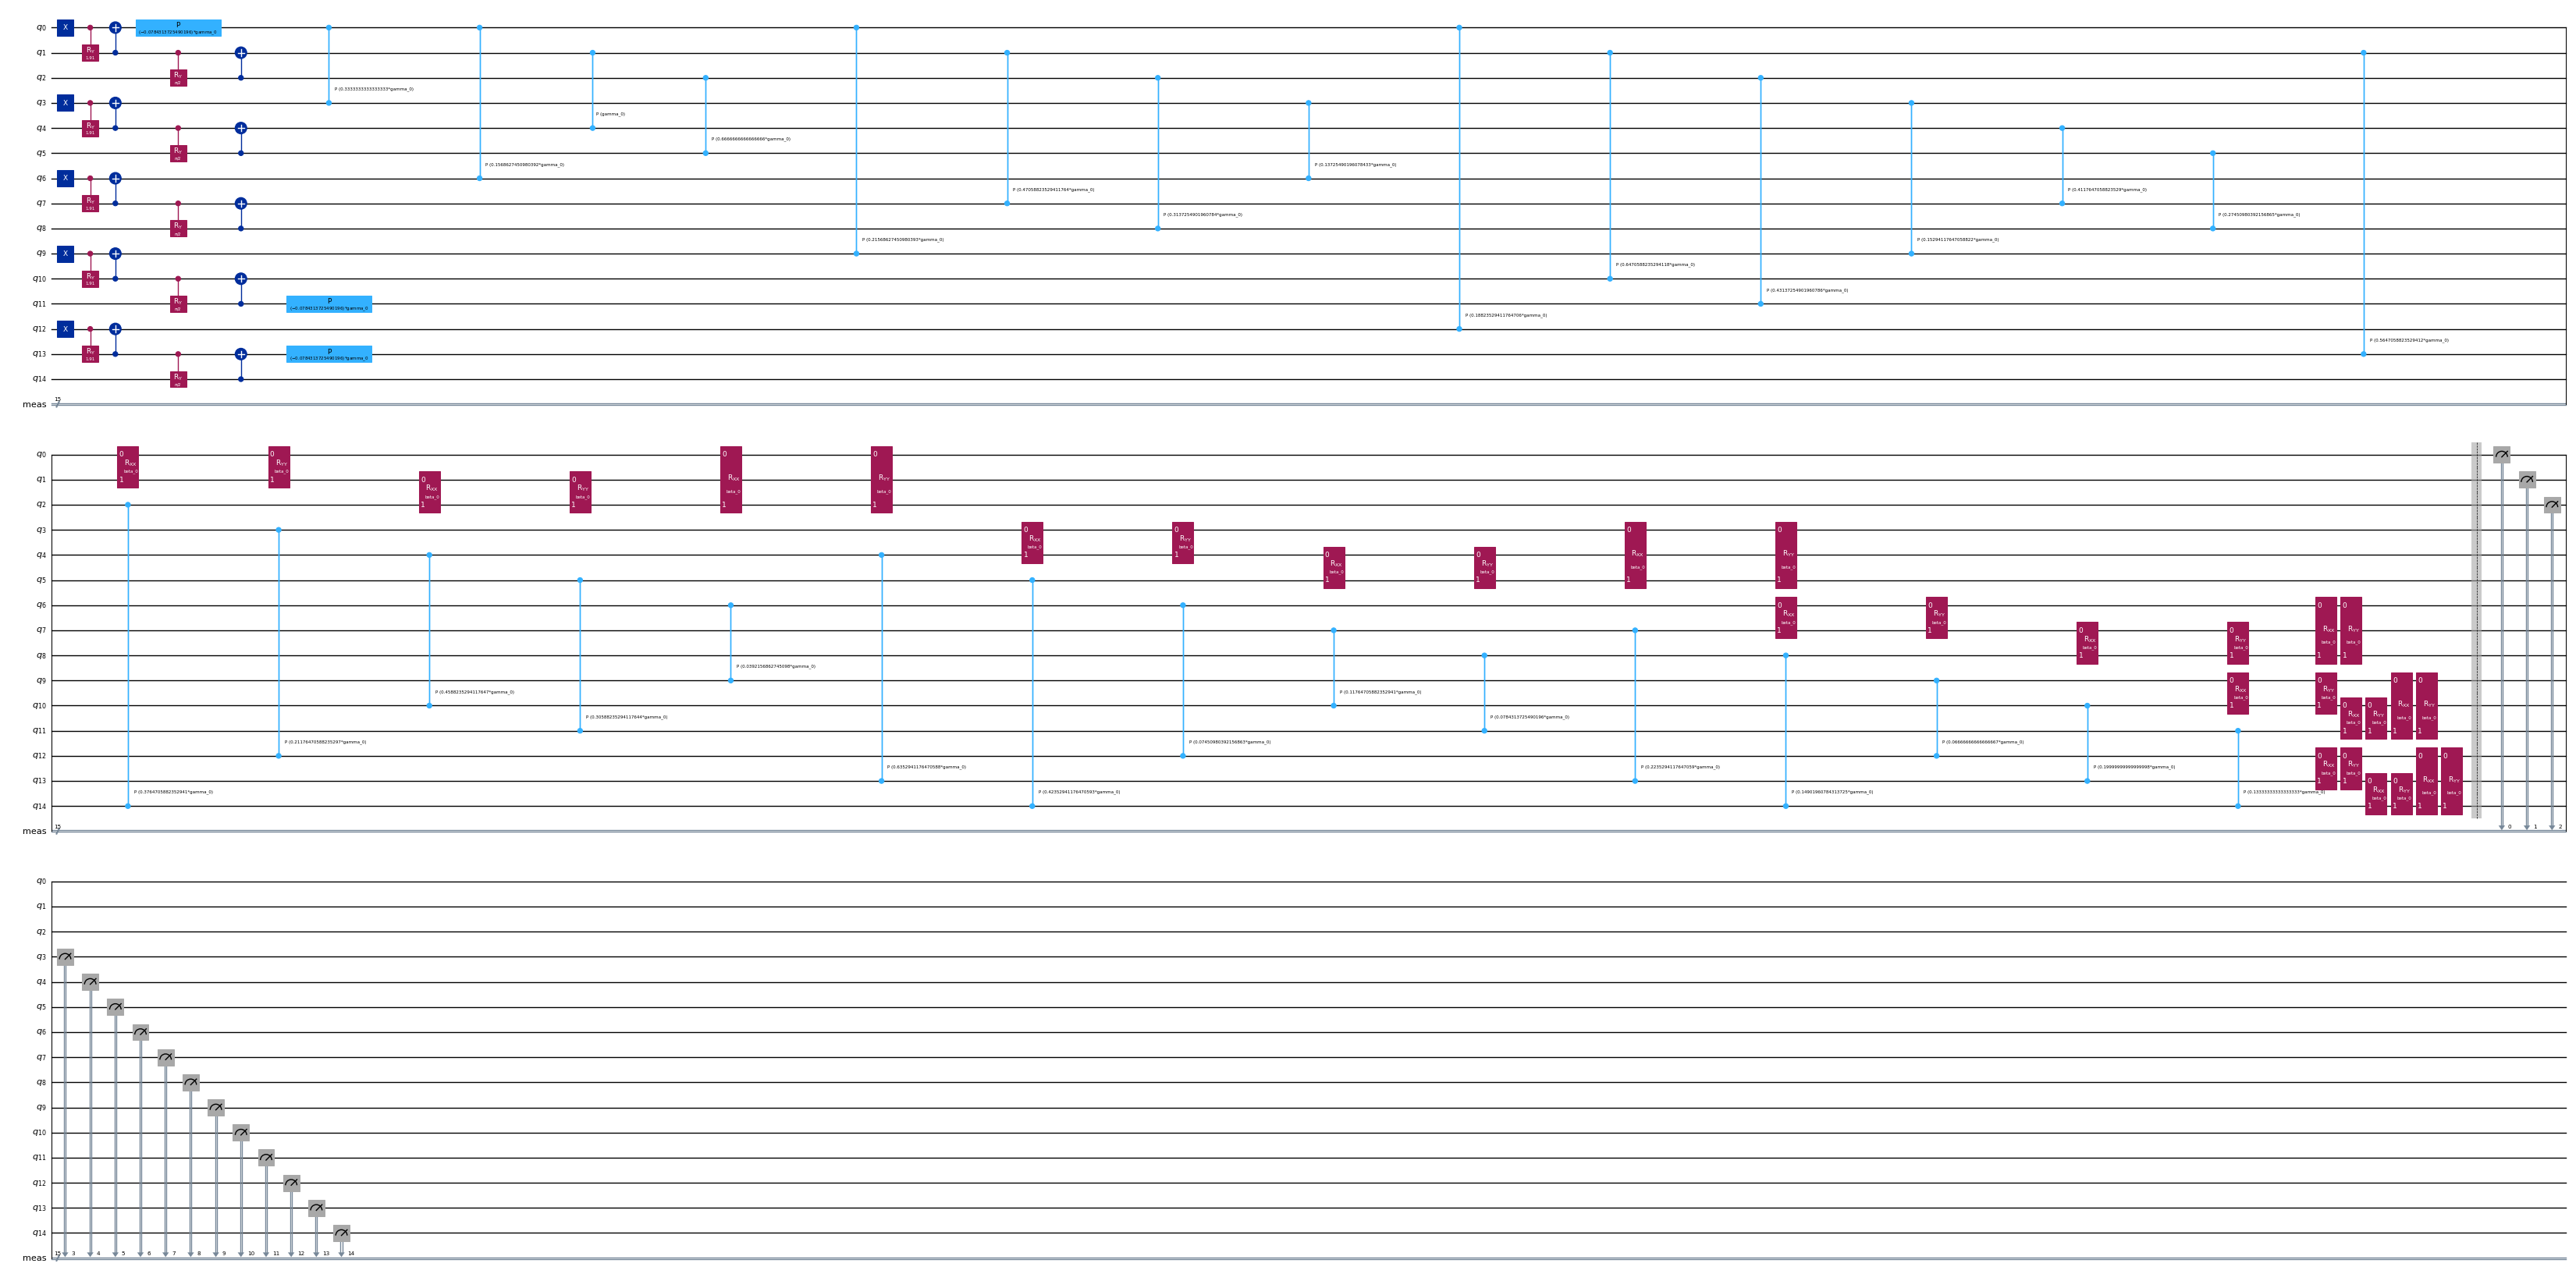

In [17]:
# Let's draw the full circuit with XY-mixers
qaoa_circ_adv(ir).draw("mpl", scale=0.5, fold=100)

### Peformance with Optimization

=== Running optimization for p=1 layers ===
Circuit depth: 19, Parameters: 2
Iteration 5: Energy = 18.193
Iteration 10: Energy = 15.915
Iteration 15: Energy = 14.729
Iteration 20: Energy = 14.638
Iteration 25: Energy = 14.683
-------------------------
Energy: 14.413
Best objective value: 2.800

=== Running optimization for p=2 layers ===
Circuit depth: 30, Parameters: 4
Iteration 5: Energy = 18.095
Iteration 10: Energy = 16.352
Iteration 15: Energy = 15.779
Iteration 20: Energy = 15.706
Iteration 25: Energy = 15.846
Iteration 30: Energy = 15.742
-------------------------
Energy: 15.429
Best objective value: 2.800

=== Running optimization for p=3 layers ===
Circuit depth: 41, Parameters: 6
Iteration 5: Energy = 14.241
Iteration 10: Energy = 13.827
Iteration 15: Energy = 13.746
Iteration 20: Energy = 13.662
Iteration 25: Energy = 13.806
Iteration 30: Energy = 13.871
-------------------------
Energy: 13.527
Best objective value: 2.800

=== Running optimization for p=4 layers ===
Circuit 

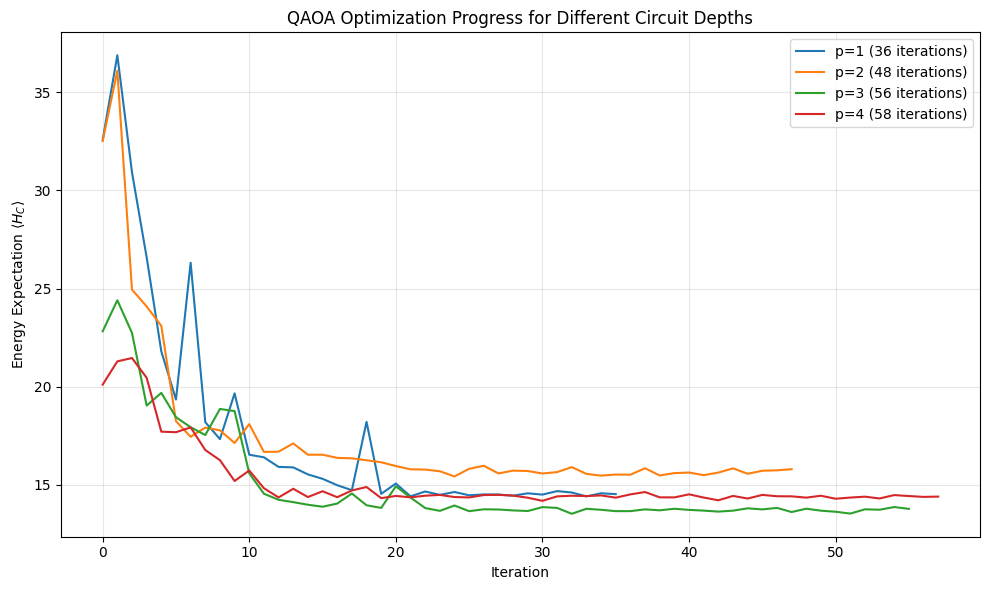

In [18]:
def circuit(p: int):
    return qaoa_circ_adv(ir, p)


final_solution, best = optimize_and_plot(circuit, ir.model, range(1, 5, 1), shots=10000)
final_solution = pass_manager.backwards(final_solution, ir)

In [19]:
# Double check the Feasibility Ratio
final_solution.feasibility_ratio()

1.0

In [20]:
pretty(final_solution)

x_016_0,x_016_1,x_016_2,x_028_0,x_028_1,x_028_2,x_020_0,x_020_1,x_020_2,x_031_0,x_031_1,...
1,0,0,0,1,0,0,0,1,0,0,
1,0,0,0,1,0,1,0,0,0,0,
1,0,0,1,0,0,0,0,1,0,0,
0,0,1,0,1,0,1,0,0,1,0,
0,1,0,0,0,1,1,0,0,1,0,
0,1,0,1,0,0,1,0,0,0,0,
1,0,0,0,0,1,1,0,0,0,1,
1,0,0,0,1,0,0,0,1,0,0,
0,1,0,1,0,0,0,0,1,0,0,
1,0,0,0,0,1,0,1,0,0,1,


### Visualization of the Best Result

Let's put the chairs in their assigned rooms

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

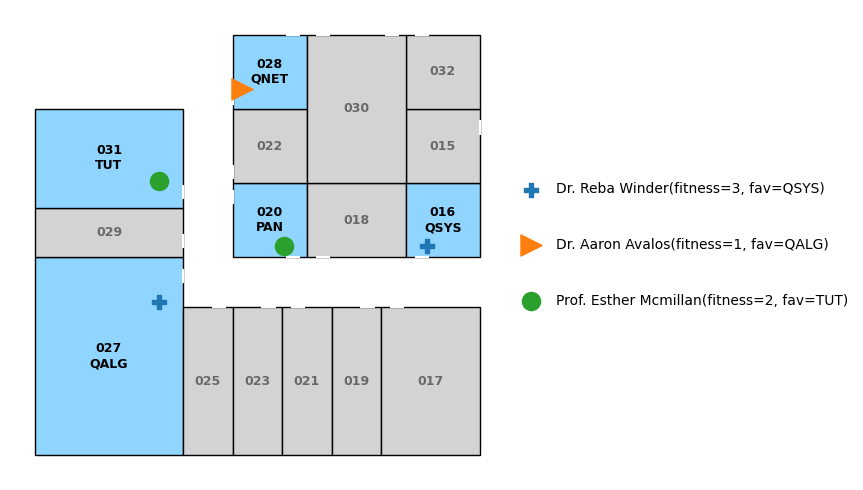

In [21]:
assignment = solution_to_assignment(final_solution, chairs)
plot_floor_plan(center, schedule=schedule, chairs=chairs, assignment=assignment)

---

## 🎉 Congratulations!

You've successfully completed this tutorial! We hope you found it helpful and informative.

### 📖 References & Further Reading
This tutorial was built upon the following resources:

- D. Cruz et al., 2014: Efficient Quantum Algorithms for GHZ and W States [[Paper]](https://arxiv.org/abs/1807.05572)
- S. Hadfield et al., 2019: From the Quantum Approximate Optimization Algorithm to a Quantum Alternating Operator Ansatz [[Paper]](https://arxiv.org/abs/1709.03489)

### 🚀 Coming Up Next

In the [next tutorial](04_Aqarios_Luna.ipynb), we will explore Aqarios' Luna Platform and take our first look at FlexQAOA, which also implements the XY-Mixers.

---
## 💡 Ready to dive deeper?

Explore more tutorials, documentation, and resources to accelerate your journey

<img src="https://docs.aqarios.com/assets/aqarios.png#only-light" width="400px" alt="Aqarios Logo" />

[![Website](https://img.shields.io/badge/🌐_Website-Visit_Aqarios.com-blue?style=for-the-badge)](https://www.aqarios.com)
[![Documentation](https://img.shields.io/badge/📚_Documentation-Explore_Docs-green?style=for-the-badge)](https://docs.aqarios.com)
[![LinkedIn](https://img.shields.io/badge/🤝_LinkedIn-Connect_With_Us-0077B5?style=for-the-badge&logo=linkedin)](https://www.linkedin.com/company/aqarios-gmbh/)


**What's Next?**

- **Explore our documentation** for advanced features and best practices
- **Join our community** on LinkedIn for updates and discussions  
- **Check out more tutorials** to expand your skills

### 💬 Need Help?

Have questions or feedback about this tutorial? We'd love to hear from you! Connect with us through any of the links above.

---

<div align="center">
<small>

Tutorial provided by Aqarios GmbH | © 2025 Aqarios GmbH | Made with ❤️ for developers

</small>
</div>